In [13]:
!python -m pip install tqdm nb-black

In [14]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import base64
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import shap

In [51]:
df = pd.read_csv("../data/processed/MVA_cleaned_merged.csv")

In [52]:
df.head()

,Behavioral Crisis Num,CAD Event ID,Disposition,Exhibiting Behavior (group),Subject Age,Techniques Used,UoF Indicator,Weapons Involved,Reported Date,Officer Serial Num,...,Clear Year,Clear Month,Clear Weekday,Clear Hour,CIT Certified Ind,Incident Type,Officer Gender,Officer Race,Subject Gender,Subject Race
0,43653,20150000159907,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-15,7654.0,...,2015.0,5.0,4.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,43653,20150000159907,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-15,7789.0,...,2015.0,5.0,4.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2,43719,20150000160408,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-16,7692.0,...,2015.0,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,43719,20150000160408,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-16,7787.0,...,2015.0,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
4,43719,20150000160408,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-16,7568.0,...,2015.0,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Select relevant variables
df_model = df[['Behavioral Crisis Num', 'CAD Event ID', 'Officer Serial Num', #IDs to check for duplicates
    'UoF Indicator', # response variable
    'Disposition', 'Exhibiting Behavior (group)', 'Subject Age', 
    'Subject Gender', 'Subject Race', 'Techniques Used', 'Weapons Involved',
    'Call Priority Code', 'Total Service Time', 'Blurred_Latitude', 
    'Blurred_Longitude',
    'CIT Certified Ind','Incident Type', 'Officer Gender', 'Officer Race']].reset_index(drop=True)

In [54]:
# Editing column names
df_model.rename(columns={"Blurred_Latitude": "Latitude", 
                         "Blurred_Longitude":"Longitude",
                         "Exhibiting Behavior (group)":"Exhibiting Behavior"}, inplace=True)
df_model.columns = df_model.columns.str.replace(' ', '_')
df_model.columns

Index(['Behavioral_Crisis_Num', 'CAD_Event_ID', 'Officer_Serial_Num',
       'UoF_Indicator', 'Disposition', 'Exhibiting_Behavior', 'Subject_Age',
       'Subject_Gender', 'Subject_Race', 'Techniques_Used', 'Weapons_Involved',
       'Call_Priority_Code', 'Total_Service_Time', 'Latitude', 'Longitude',
       'CIT_Certified_Ind', 'Incident_Type', 'Officer_Gender', 'Officer_Race'],
      dtype='object')

In [55]:
# Drop duplicates considering new selected features
df_model.drop_duplicates(subset=df_model.columns, inplace=True)

In [56]:
# Replacing missing values for NaN
df_model.replace({'-': np.nan}, inplace=True)
df_model.replace({-1: np.nan}, inplace=True)

In [57]:
#Check on the % of null values
df_model.isnull().sum()*100/df_model.shape[0]

Behavioral_Crisis_Num     0.000000
CAD_Event_ID              0.000000
Officer_Serial_Num        3.940026
UoF_Indicator             0.000000
Disposition               1.431721
Exhibiting_Behavior      10.254594
Subject_Age              43.666618
Subject_Gender           98.470381
Subject_Race             98.470381
Techniques_Used          40.991621
Weapons_Involved         40.991621
Call_Priority_Code        3.944730
Total_Service_Time        3.940026
Latitude                  6.219021
Longitude                 6.219021
CIT_Certified_Ind        98.470381
Incident_Type            98.470381
Officer_Gender           98.470381
Officer_Race             98.470381
dtype: float64

In [58]:
df_model['CIT_Certified_Ind'].value_counts()

Y    2883
N    2320
Name: CIT_Certified_Ind, dtype: int64

In [59]:
# Drop NaN
df_model.dropna(subset=['CIT_Certified_Ind'], inplace = True)
#df_model.dropna( inplace = True)
df_model.shape

(5203, 19)

In [60]:
#Check on the % of null values
df_model.isnull().sum()*100/df_model.shape[0]

Behavioral_Crisis_Num     0.000000
CAD_Event_ID              0.000000
Officer_Serial_Num        0.000000
UoF_Indicator             0.000000
Disposition               0.480492
Exhibiting_Behavior       2.825293
Subject_Age              35.575629
Subject_Gender            0.000000
Subject_Race              0.000000
Techniques_Used          33.461465
Weapons_Involved         33.461465
Call_Priority_Code        0.000000
Total_Service_Time        0.000000
Latitude                  2.364021
Longitude                 2.364021
CIT_Certified_Ind         0.000000
Incident_Type             0.000000
Officer_Gender            0.000000
Officer_Race              0.000000
dtype: float64

In [61]:
# Dropping all NaN
df_model.dropna( inplace = True)
df_model.shape

(3255, 19)

In [62]:
df_model.head()

,Behavioral_Crisis_Num,CAD_Event_ID,Officer_Serial_Num,UoF_Indicator,Disposition,Exhibiting_Behavior,Subject_Age,Subject_Gender,Subject_Race,Techniques_Used,Weapons_Involved,Call_Priority_Code,Total_Service_Time,Latitude,Longitude,CIT_Certified_Ind,Incident_Type,Officer_Gender,Officer_Race
47822,8.207774e+09,2.019000e+13,8365.0,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,57.0,47.610682,-122.34196,N,Level 1 - Use of Force,F,White
47837,8.207774e+09,2.019000e+13,8615.0,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,22.0,47.610682,-122.34196,N,Level 1 - Use of Force,M,Hispanic or Latino
47848,8.207774e+09,2.019000e+13,8525.0,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,6.0,47.610682,-122.34196,Y,Level 1 - Use of Force,M,White
47849,8.207774e+09,2.019000e+13,7482.0,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,23.0,47.610682,-122.34196,N,Level 1 - Use of Force,M,White
47880,8.207774e+09,2.019000e+13,8365.0,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,HANDCUFFING,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,57.0,47.610682,-122.34196,N,Level 1 - Use of Force,F,White


In [63]:
df_model['UoF_Indicator'].value_counts()

YES    3006
NO      249
Name: UoF_Indicator, dtype: int64

In [64]:
# Drop ID cols
df_model.drop(["Behavioral_Crisis_Num", "CAD_Event_ID", "Officer_Serial_Num"], axis = 1, inplace=True)
df_model.head()

,UoF_Indicator,Disposition,Exhibiting_Behavior,Subject_Age,Subject_Gender,Subject_Race,Techniques_Used,Weapons_Involved,Call_Priority_Code,Total_Service_Time,Latitude,Longitude,CIT_Certified_Ind,Incident_Type,Officer_Gender,Officer_Race
47822,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,57.0,47.610682,-122.34196,N,Level 1 - Use of Force,F,White
47837,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,22.0,47.610682,-122.34196,N,Level 1 - Use of Force,M,Hispanic or Latino
47848,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,6.0,47.610682,-122.34196,Y,Level 1 - Use of Force,M,White
47849,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,GURNEY,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,23.0,47.610682,-122.34196,N,Level 1 - Use of Force,M,White
47880,YES,ARRESTED,BELLIGERENT/UNCOOPERATIVE,26.0,M,Not Specified,HANDCUFFING,"PERSONAL WEAPONS (HANDS, FEET, ETC.)",2.0,57.0,47.610682,-122.34196,N,Level 1 - Use of Force,F,White


In [65]:
# Apply One hot encoding to categorical variables
y = df_model['UoF_Indicator']
X = pd.get_dummies(df_model.loc[:,df_model.columns!='UoF_Indicator'])
X.head()

,Subject_Age,Call_Priority_Code,Total_Service_Time,Latitude,Longitude,Disposition_ARRESTED,Disposition_CHRONIC COMPLAINT,Disposition_DMHP/REFERRAL (DCR),Disposition_EMERGENT DETENTION/ITA,Disposition_NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,...,Officer_Gender_F,Officer_Gender_M,Officer_Race_American Indian/Alaska Native,Officer_Race_Asian,Officer_Race_Black or African American,Officer_Race_Hispanic or Latino,Officer_Race_Nat Hawaiian/Oth Pac Islander,Officer_Race_Not Specified,Officer_Race_Two or More Races,Officer_Race_White
47822,26.0,2.0,57.0,47.610682,-122.34196,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
47837,26.0,2.0,22.0,47.610682,-122.34196,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
47848,26.0,2.0,6.0,47.610682,-122.34196,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
47849,26.0,2.0,23.0,47.610682,-122.34196,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
47880,26.0,2.0,57.0,47.610682,-122.34196,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [66]:
# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [67]:
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [68]:
# Evaluating performance
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')

In [69]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 80   8]
 [  0 987]]


=== Classification Report ===
              precision    recall  f1-score   support

          NO       1.00      0.91      0.95        88
         YES       0.99      1.00      1.00       987

    accuracy                           0.99      1075
   macro avg       1.00      0.95      0.97      1075
weighted avg       0.99      0.99      0.99      1075



=== All AUC Scores ===
[0.99807309 1.         1.         0.98066445 0.61614618 1.
 1.         0.99966667 0.9792     0.9322    ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9505950387596899


In [70]:
# Feature importance
## impurity-based importance.
importances = rfc.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

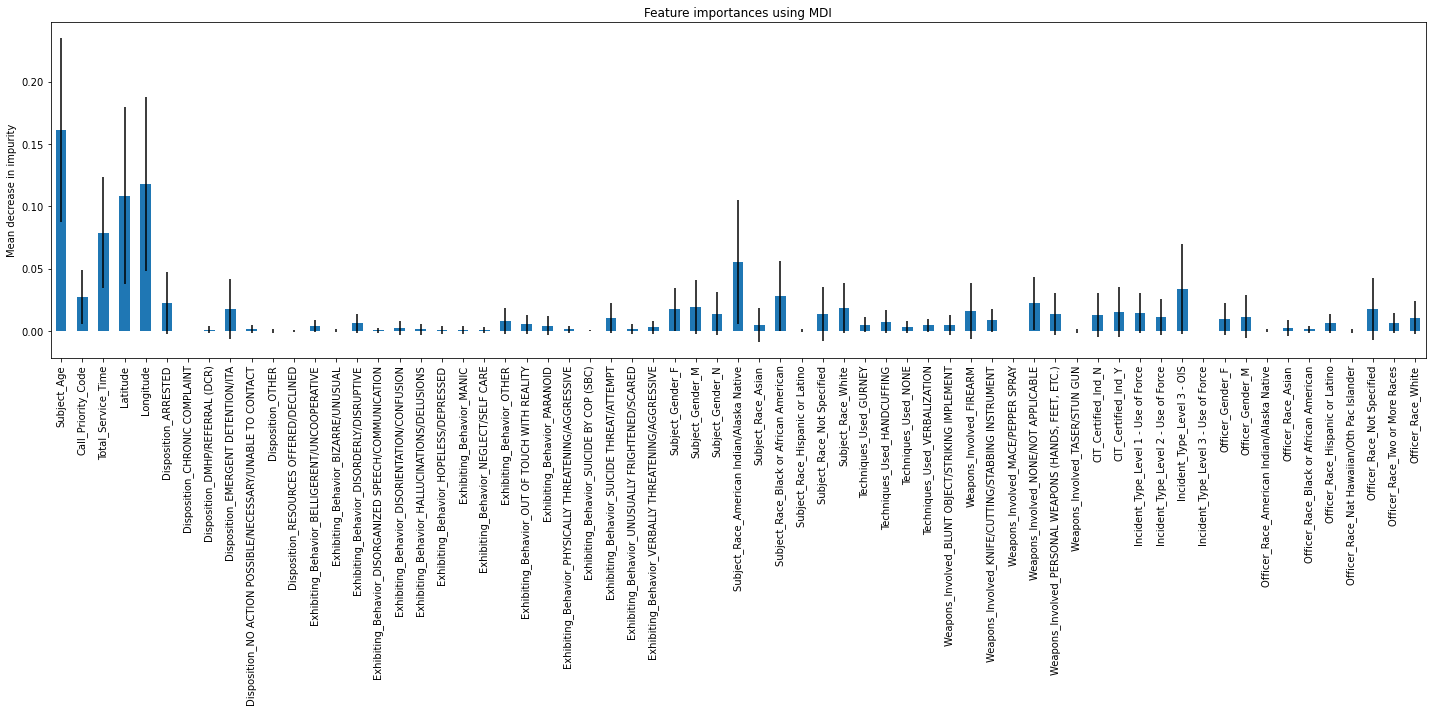

In [71]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [72]:
## Feature importance based on feature permutation
result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

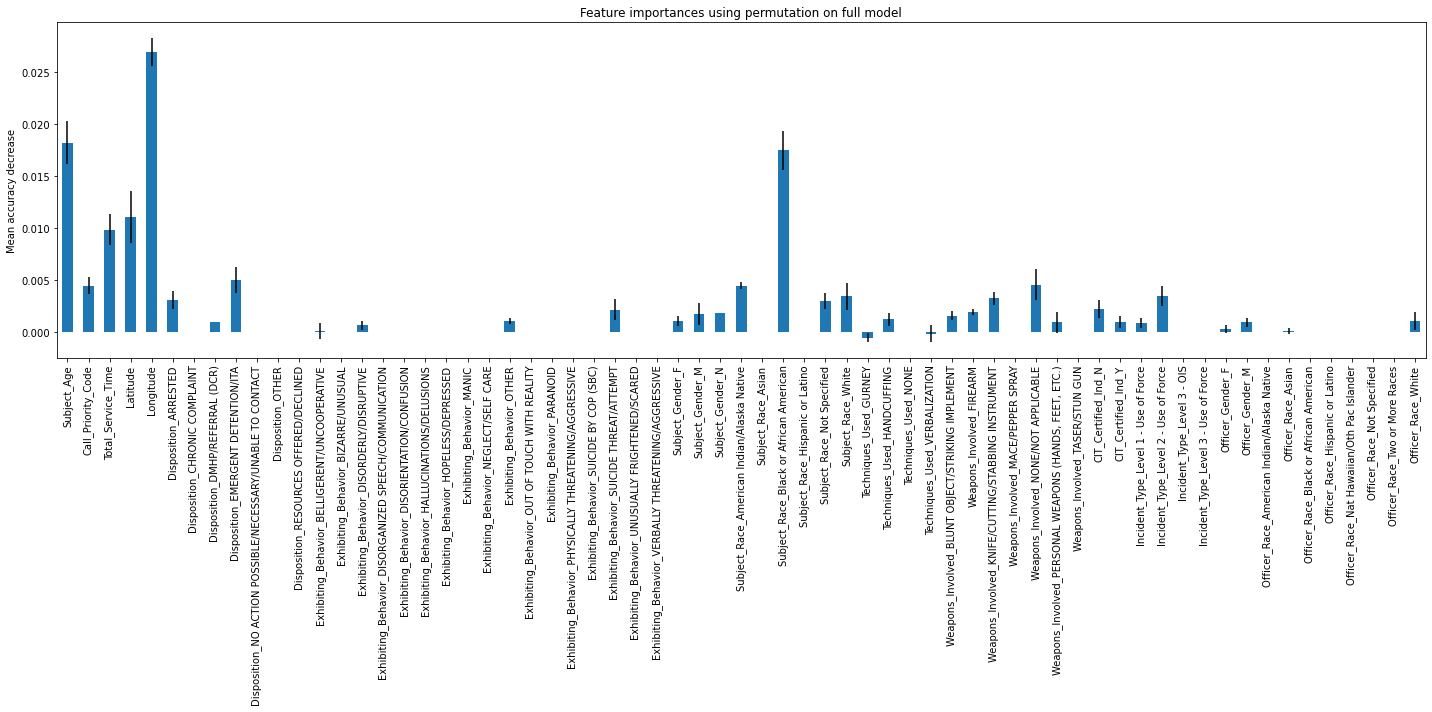

In [73]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

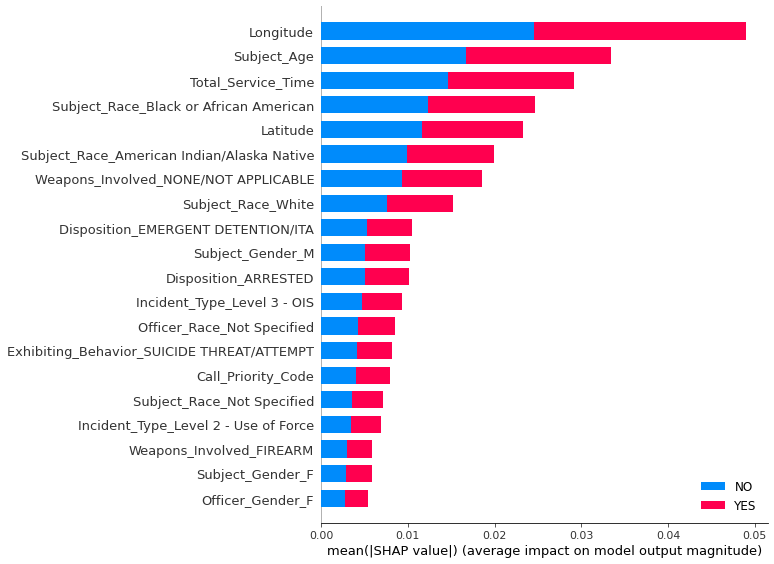

In [74]:
shap_values = shap.TreeExplainer(rfc).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=rfc.classes_)

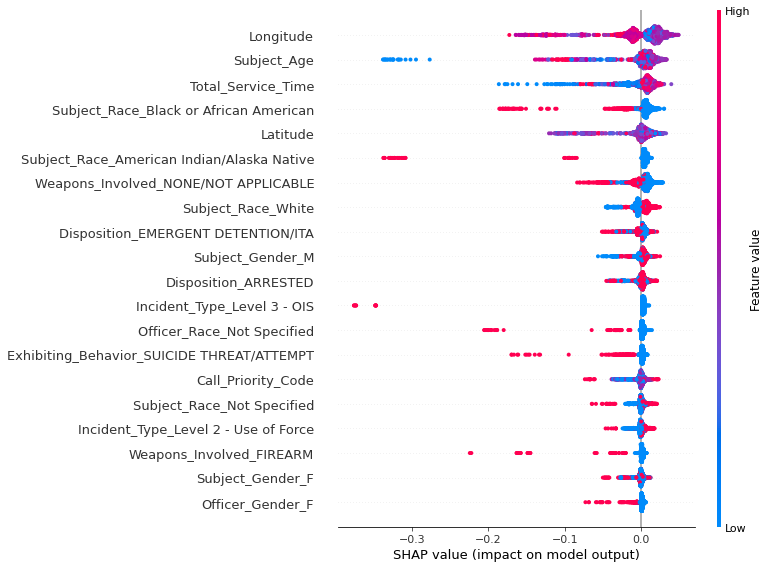

In [75]:
f = plt.figure()
shap.summary_plot(shap_values[1], X_train, class_names=rfc.classes_)